In [1]:
import os
from os.path import dirname
import sys
import gym
import torch
try:
    dir_ = dirname(dirname(__file__))
except Exception as e:
    dir_ = dirname(dirname('__file__'))

if len(dir_) == 0:
    dir_ = dirname(os.getcwd())

print(dir_)
sys.path.append(dir_)
from RLAlgo.TD3 import TD3
from RLUtils import train_off_policy, play, Config, gym_env_desc
import numpy as np
from RLUtils.env_wrapper import FrameStack, CarV2SkipFrame, GrayScaleObservation, ResizeObservation
import matplotlib.pyplot as plt

/home/scc/sccWork/myGitHub/RL/src


In [2]:
def random_action(env):
    return np.random.uniform(env.action_space.low, env.action_space.high)

# CarRacing-v2

In [3]:
env_name = 'CarRacing-v2'
env_ = gym.make(env_name, render_mode=None)
env_.action_space.low, env_.action_space.high

(array([-1.,  0.,  0.], dtype=float32), array([1., 1., 1.], dtype=float32))

/home/scc/anaconda3/envs/sccRL/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


[0.48319025 0.90873688 0.05730424]
======================== SET SKIP_N = 5 ========================


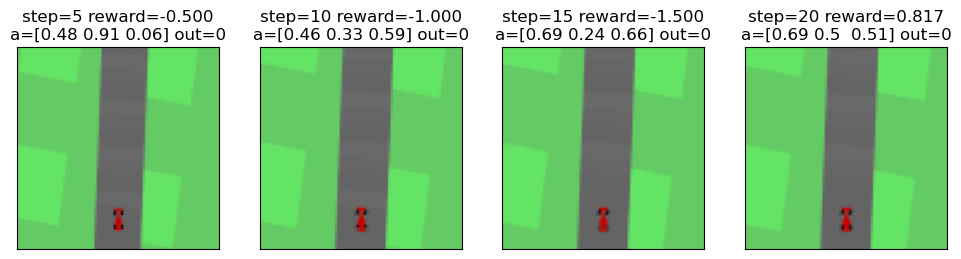

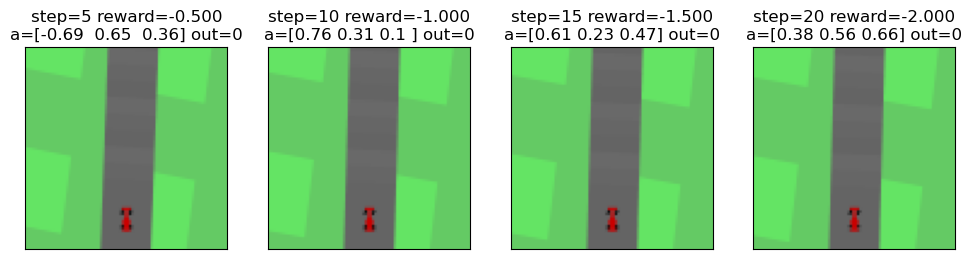

In [4]:
s, info = env_.reset()
a = np.array([0.0, 0.0, 1.0])
for i in range(40):
    obs, reward, done, info, _ = env_.step(a)

a = random_action(env_)
print(a)
SKIP_N = 5
print(f"======================== SET SKIP_N = {SKIP_N} ========================")
tt_r = 0
fig, axes = plt.subplots(1, 4, figsize=(4*3, 3))
ax_idx = 0
for idx, i in enumerate(range(SKIP_N * 4)):
    s, reward, done, info1, info2 = env_.step(a)
    s = s[:84, 6:90]
    tt_r += reward
    if (1+idx) % SKIP_N == 0:
        axes[ax_idx].imshow(s)
        axes[ax_idx].set_xticks([])
        axes[ax_idx].set_yticks([])
        a_s = np.round(a, 2)
        out = ((s[75, 35:50, 1][:2] > 200).sum() + (s[75, 35:50, 1][-2:] > 200).sum()) == 4
        out *= 1
        axes[ax_idx].set_title(f'step={idx+1} reward={tt_r:.3f}\na={a_s} out={out}')
        ax_idx += 1
        a = random_action(env_)

plt.show()

tt_r = 0
fig, axes = plt.subplots(1, 4, figsize=(4*3, 3))
ax_idx = 0
for idx, i in enumerate(range(SKIP_N * 4)):
    s, reward, done, info1, info2 = env_.step(a)
    s = s[:84, 6:90]
    tt_r += reward
    if (1+idx) % SKIP_N == 0:
        axes[ax_idx].imshow(s)
        axes[ax_idx].set_xticks([])
        axes[ax_idx].set_yticks([])
        a_s = np.round(a, 2)
        out = ((s[75, 35:50, 1][:2] > 200).sum() + (s[75, 35:50, 1][-2:] > 200).sum()) == 4
        out *= 1
        axes[ax_idx].set_title(f'step={idx+1} reward={tt_r:.3f}\na={a_s} out={out}')
        ax_idx += 1
        a = random_action(env_)

plt.show()


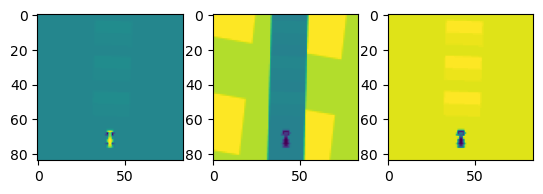

In [5]:
fig, axes = plt.subplots(1, 3)
# s = obs[:84, 6:90]
for i in range(3):
    axes[i].imshow(s[:, :, i])

# red green blue
plt.show()

In [6]:
print(s.shape)
print(s[75, :, 1])

# > 200
# s[75, 30:50, 0], 
s[75, 35:50, 1], (s[75, 35:50, 1][:2] > 200).sum() + (s[75, 35:50, 1][-2:] > 200).sum()

(84, 84, 3)
[228 228 228 228 228 228 228 228 228 228 228 228 228 228 228 223 202 202
 202 202 202 202 202 202 202 202 202 202 202 202 202 173 100 100 100 100
 100 100 100  95  54  11  11  54  95 100 100 100 100 100 100 100 158 228
 228 228 228 228 228 228 228 228 228 228 228 228 228 228 206 202 202 202
 202 202 202 202 202 202 202 202 202 202 202 202]


(array([100, 100, 100, 100,  95,  54,  11,  11,  54,  95, 100, 100, 100,
        100, 100], dtype=uint8),
 0)

In [7]:
torch.normal(0, 1, (2, 2))

tensor([[ 0.0270, -0.9929],
        [ 1.5632, -0.0926]])

## preprocessing Obs

In [8]:
env = gym.make(env_name)
SKIP_N = 10
STACK_N = 4
env_ = FrameStack(
    ResizeObservation(
        GrayScaleObservation(CarV2SkipFrame(env, skip=SKIP_N)), 
        shape=84
    ), 
    num_stack=STACK_N
)

[0.21406628 0.58855265 0.9837145 ]


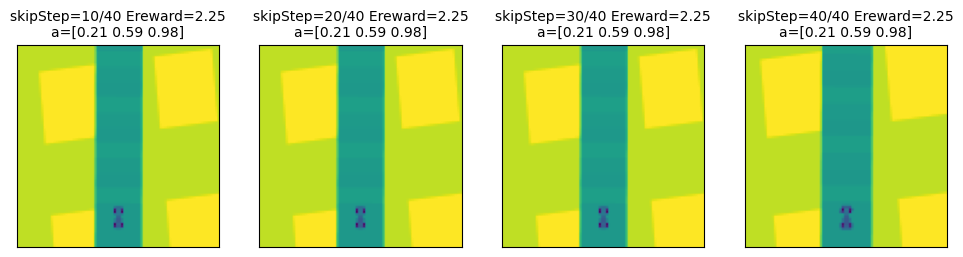

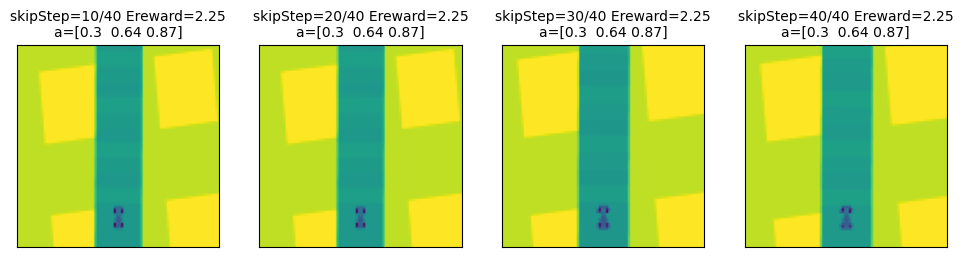

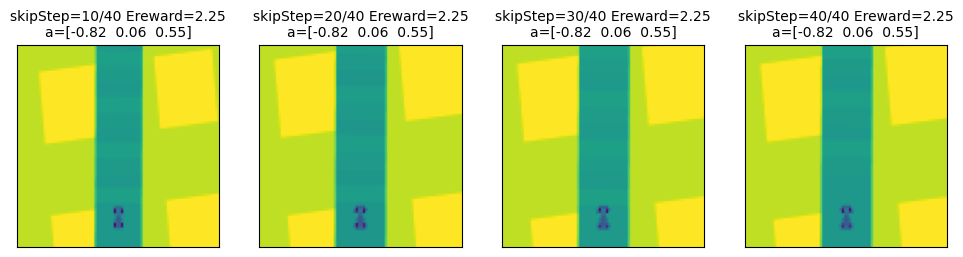

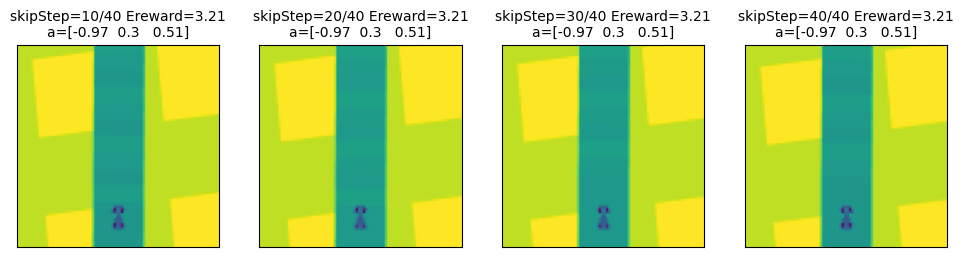

In [9]:
s, info = env_.reset()
a = random_action(env_)
print(a)
for step_i in range(4):
    s, reward, done, info1, info2 = env_.step(a)
    fig, axes = plt.subplots(1, 4, figsize=(4*3, 3))
    for ax_idx, pic in enumerate(s._frames):
        axes[ax_idx].imshow(pic)
        axes[ax_idx].set_xticks([])
        axes[ax_idx].set_yticks([])
        a_s = np.round(a, 2)
        axes[ax_idx].set_title(
            f'skipStep={SKIP_N * (ax_idx+1)}/{SKIP_N * STACK_N} Ereward={reward/4 + 2.5:.2f}\na={a_s}',
            fontsize=10
        )

    if done:
        plt.show()
        break
    a = random_action(env_)
    plt.show()

In [10]:
from torch.nn import functional as F
path_ = os.path.dirname('__file__')

cfg = Config(
    env, 
    # 环境参数
    save_path=os.path.join(path_, "test_models" ,'TD3_CarRacing-v2_test2-1'), 
    seed=42,
    # 网络参数
    actor_hidden_layers_dim=[256],
    critic_hidden_layers_dim=[256],
    # agent参数
    actor_lr=2.5e-4, # 5e-4,
    critic_lr=5e-3,
    gamma=0.99,
    # 训练参数
    num_episode=3000,
    sample_size=128,
    # 环境复杂多变，需要保存多一些buffer
    off_buffer_size=2048*20, # 2048*10, # 1024*100  
    off_minimal_size=512,
    max_episode_rewards=50000,
    max_episode_steps=2000, # 200
    # agent 其他参数
    TD3_kwargs={
        'CNN_env_flag': 1,
        'pic_shape': env.observation_space.shape,
        "env": env,
        'action_low': env.action_space.low,
        'action_high': env.action_space.high,
        # soft update parameters
        'tau': 0.05, 
        # trick2: Delayed Policy Update
        'delay_freq': 1,
        # trick3: Target Policy Smoothing
        'policy_noise': 0.2,
        'policy_noise_clip': 0.5,
        # exploration noise
        'expl_noise': 0.5,
        # 探索的 noise 指数系数率减少 noise = expl_noise * expl_noise_exp_reduce_factor^t
        'expl_noise_exp_reduce_factor': 1 - 1e-5
    }
)
agent = TD3(
    state_dim=cfg.state_dim,
    actor_hidden_layers_dim=cfg.actor_hidden_layers_dim,
    critic_hidden_layers_dim=cfg.critic_hidden_layers_dim,
    action_dim=cfg.action_dim,
    actor_lr=cfg.actor_lr,
    critic_lr=cfg.critic_lr,
    gamma=cfg.gamma,
    TD3_kwargs=cfg.TD3_kwargs,
    device=cfg.device
)

agent.load_model(cfg.save_path)
# agent.eval()

Set env random_seed = 42

device=cuda | env=<TimeLimit<OrderEnforcing<PassiveEnvChecker<CarRacing<CarRacing-v2>>>>>(state_dim=3, action_dim=3)
TD3_kwargs => {'CNN_env_flag': 1, 'pic_shape': (96, 96, 3), 'env': <TimeLimit<OrderEnforcing<PassiveEnvChecker<CarRacing<CarRacing-v2>>>>>, 'action_low': array([-1.,  0.,  0.], dtype=float32), 'action_high': array([1., 1., 1.], dtype=float32), 'tau': 0.05, 'delay_freq': 1, 'policy_noise': 0.2, 'policy_noise_clip': 0.5, 'expl_noise': 0.5, 'expl_noise_exp_reduce_factor': 0.99999}
[-1.  0.  0.] [1. 1. 1.]
action_bound= <TimeLimit<OrderEnforcing<PassiveEnvChecker<CarRacing<CarRacing-v2>>>>>


In [26]:
agent.critic.head_q1_bf.weight.grad,  agent.critic.head_q1.weight.grad, agent.critic.head_q1_bf.weight.grad.shape

(tensor([[-0.0000, -0.0000, -0.0000,  4.9533, -6.1344, -6.5899],
         [ 0.0000,  0.0000,  0.0000, -0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000, -0.0000,  0.0000,  0.0000]],
        device='cuda:0'),
 tensor([[7.7001, 0.0000, 0.0000]], device='cuda:0'),
 torch.Size([3, 6]))

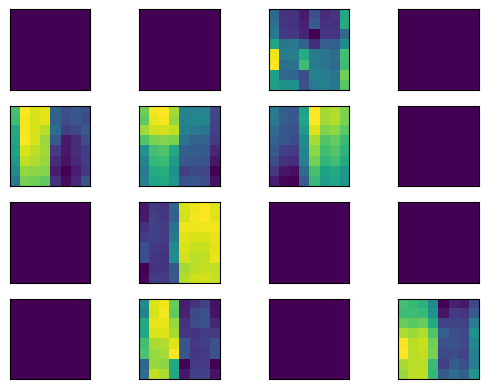

In [12]:
for n, p in agent.critic.q1_cnn_feature[0].named_parameters():
    break

fig, axes = plt.subplots(4, 4)
axes = axes.flatten()
for i, p_g in enumerate(p.grad.sum(dim=1)):
    axes[i].imshow(p_g.cpu().detach().numpy())
    axes[i].set_xticks([])
    axes[i].set_yticks([])

plt.show()

/tmp/ipykernel_1046803/3403497313.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  s_pt = torch.tensor([np.stack(s)]).float().to(agent.device)


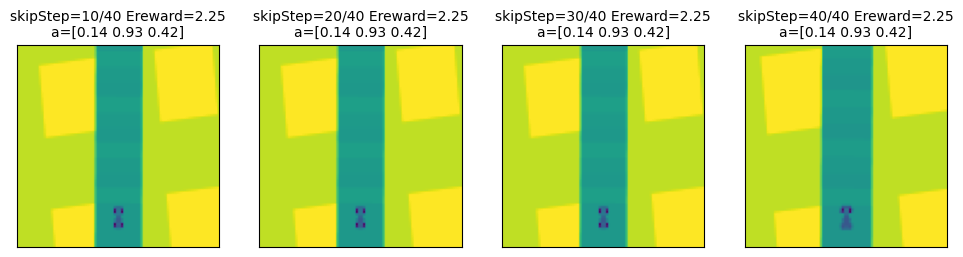

In [11]:
agent.train()
s, info = env_.reset()
for step_i in range(4):
    s_pt = torch.tensor([np.stack(s)]).float().to(agent.device)
    a = agent.policy(s)
    a_pt = torch.tensor([a]).float().to(agent.device)
    n_s, reward, done, info1, info2 = env_.step(a)
    fig, axes = plt.subplots(1, 4, figsize=(4*3, 3))
    for ax_idx, pic in enumerate(n_s._frames):
        axes[ax_idx].imshow(pic)
        axes[ax_idx].set_xticks([])
        axes[ax_idx].set_yticks([])
        a_s = np.round(a, 2)
        axes[ax_idx].set_title(
            f'skipStep={SKIP_N * (ax_idx+1)}/{SKIP_N * STACK_N} Ereward={reward/4 + 2.5:.2f}\na={a_s}',
            fontsize=10
        )
        
    # 计算目标Q
    ns_pt = torch.tensor([np.stack(n_s)]).float().to(agent.device)
    smooth_act = agent.smooth_action(ns_pt).to(agent.device)
    # trick1: **Clipped Double Q-learning**: critic中有两个`Q-net`, 每次产出2个Q值，使用其中小的
    target_Q1, target_Q2 = agent.target_critic(ns_pt, smooth_act)
    target_Q = torch.minimum(target_Q1, target_Q2)
    target_Q = reward + (1.0 - done) * agent.gamma * target_Q
    # 计算当前Q值
    current_Q1, current_Q2 = agent.critic(s_pt, a_pt)
    q_loss = F.mse_loss(current_Q1.float(), target_Q.float().detach()) + F.mse_loss(current_Q2.float(), target_Q.float().detach())
    agent.critic_opt.zero_grad()
    q_loss.backward()
    s = n_s
    break


In [19]:
agent.eval()
s1, info = env_.reset()
a = random_action(env_)
print(a)
tt_r = []
for step_i in range(20):
    s, reward, done, info1, info2 = env_.step(a)
    a = agent.policy(s)
    print(np.round(a, 3))

[-0.68796272  0.15599452  0.05808361]
[1. 1. 1.]
[0.71  0.737 0.455]
[0.538 0.    1.   ]
[1.    0.238 0.527]
[0.629 0.648 0.   ]
[0.685 1.    1.   ]
[1.    1.    0.483]
[0.7   1.    0.887]
[0.682 0.489 0.66 ]
[0.733 0.997 0.626]
[1.    0.368 1.   ]
[1.   1.   0.85]
[1.    0.496 0.   ]
[1.    0.731 0.068]
[0.56  0.435 0.808]
[1. 1. 1.]
[1.    0.896 0.429]
[0.246 1.    0.652]
[0.795 1.    0.292]
[1.    1.    0.222]


  0%|          | 0/120 [00:00<?, ?it/s]

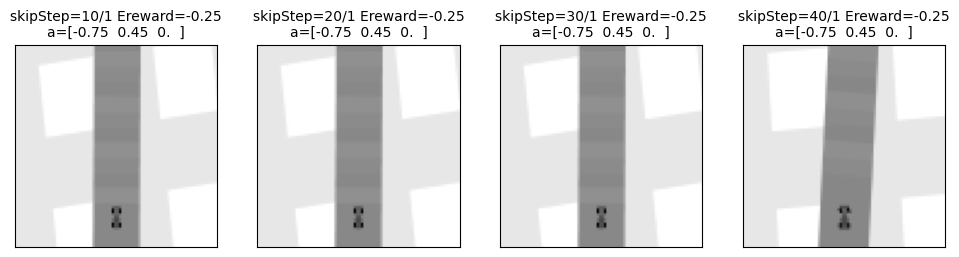

  1%|          | 1/120 [00:00<00:13,  9.04it/s]

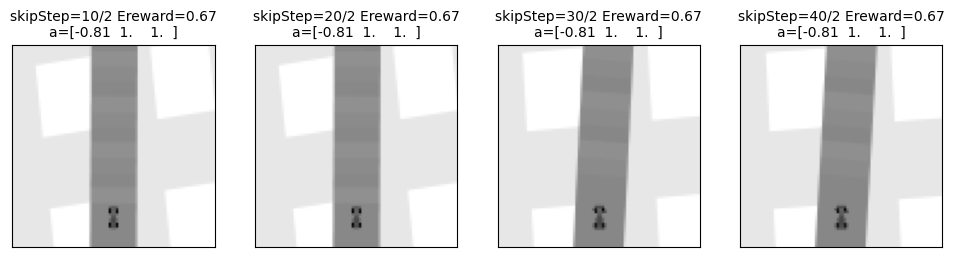

  2%|▏         | 2/120 [00:00<00:13,  9.04it/s]

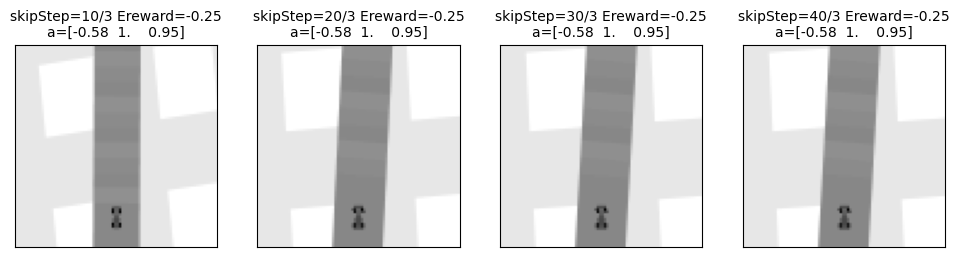

  2%|▎         | 3/120 [00:00<00:12,  9.04it/s]

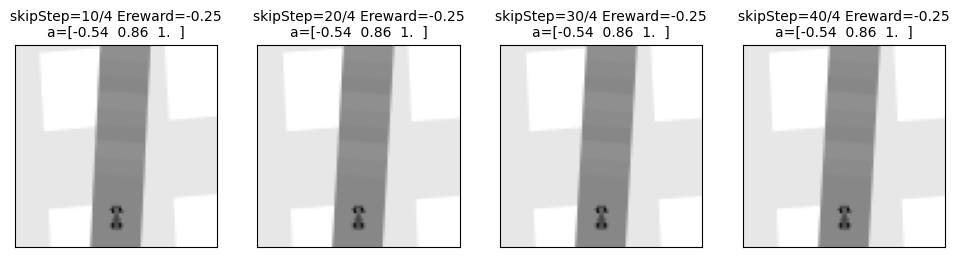

  3%|▎         | 4/120 [00:00<00:12,  9.09it/s]

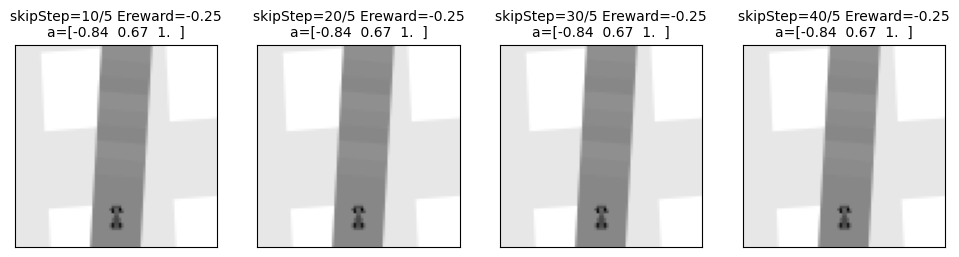

  4%|▍         | 5/120 [00:00<00:12,  9.11it/s]

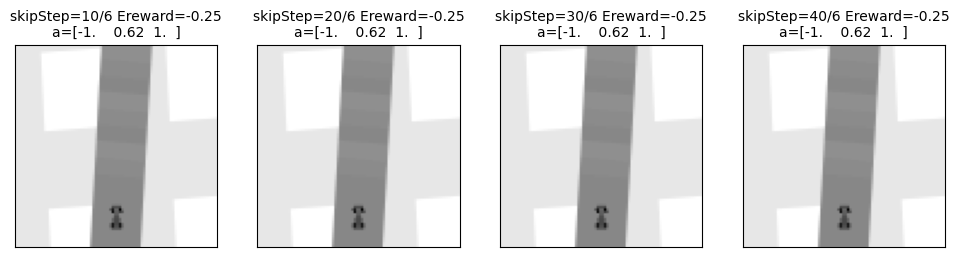

 84%|████████▍ | 101/120 [00:04<00:00, 60.63it/s]

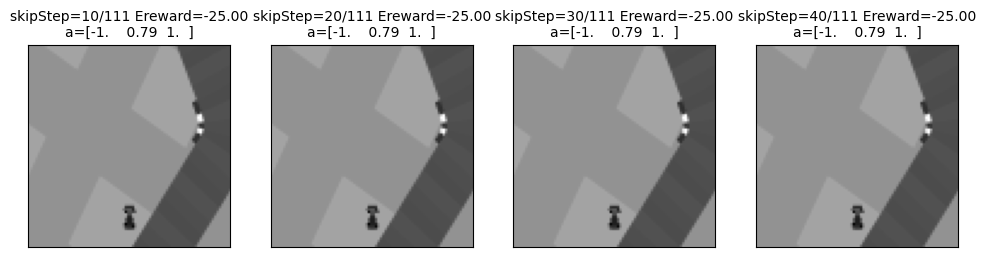

 92%|█████████▏| 110/120 [00:04<00:00, 26.04it/s]

step_i=110
[-1.0000000000000009, 2.676470588235297, -0.9999999999999987, -1.0000000000000009, -1.0000000000000009, -1.0000000000000004, -0.9999999999999999, -1.0000000000000004, -1.0000000000000007, -1.0000000000000009, -0.9999999999999991, -0.9999999999999964, -0.9999999999999964, 2.676470588235296, -0.9999999999999973, -0.9999999999999964, -0.9999999999999964, -0.9999999999999964, -0.9999999999999964, -0.9999999999999964, -0.9999999999999964, -0.9999999999999964, 2.676470588235297, -0.9999999999999964, -0.9999999999999964, -0.9999999999999964, 2.676470588235297, -0.9999999999999964, -0.9999999999999964, -0.9999999999999964, -0.9999999999999964, -0.9999999999999964, -0.9999999999999964, -1.0000000000000036, -1.0000000000000142, 2.6764705882352864, -0.9999999999999964, -1.0000000000000107, -1.0000000000000142, -1.0000000000000142, 2.676470588235283, -1.0000000000000142, -1.0000000000000142, -1.0000000000000142, -1.0000000000000142, -1.0000000000000142, -1.0000000000000142, -1.000000000

In [91]:
from  tqdm import tqdm
s, info = env_.reset()
# a = random_action(env_)
tt_r = []
for step_i in tqdm(range(120)):
    a = agent.policy(s)
    s, reward, done, info1, info2 = env_.step(a)
    tt_r.append(reward)
    if (step_i >= 110) or (step_i <= 5):
        fig, axes = plt.subplots(1, 4, figsize=(4*3, 3))
        for ax_idx, pic in enumerate(s._frames):
            axes[ax_idx].imshow(pic, cmap='gray')
            axes[ax_idx].set_xticks([])
            axes[ax_idx].set_yticks([])
            a_s = np.round(a, 2)
            axes[ax_idx].set_title(
                f'skipStep={SKIP_N * (ax_idx+1)}/{step_i + 1} Ereward={reward/4:.2f}\na={a_s}',
                fontsize=10
            )

        if done:
            plt.show()
            print(f"step_i={step_i}")
            break
        plt.show()

print(tt_r)
print(np.sum(tt_r))

In [117]:
s_sp = s._frames[-1] 
s_sp[s_sp > 0.627]

torch.Size([1710])

torch.Size([84, 84])


tensor([0.4117, 0.4117, 0.4117, 0.4117, 0.4255, 0.5174, 0.6246, 0.6269, 0.6269,
        0.6269, 0.6269, 0.6269, 0.6269, 0.6292, 0.6753, 0.6868, 0.6868, 0.6868,
        0.6868, 0.6868, 0.6868, 0.6868, 0.6868, 0.6868, 0.6868, 0.6868, 0.6868,
        0.6868, 0.6868, 0.6868, 0.6868, 0.6868, 0.6868, 0.6868, 0.6868, 0.6868,
        0.6868, 0.6868, 0.6868, 0.6868, 0.6868, 0.6868, 0.6868, 0.6868, 0.6568,
        0.6269, 0.6269, 0.6269, 0.6269, 0.6269, 0.6269, 0.6269, 0.6269, 0.6269,
        0.6269, 0.6269, 0.6269, 0.6269, 0.6269, 0.6269, 0.6269, 0.6269, 0.6269,
        0.6269, 0.6269, 0.6269, 0.6269, 0.6269, 0.6269, 0.6269, 0.6269, 0.6269,
        0.6269, 0.6269, 0.6269, 0.6269, 0.6269, 0.6269, 0.6269, 0.6269, 0.6269,
        0.6269, 0.6269, 0.6269])